### Cconfirming the presence of a GPU

In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    print("GPU Name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# Perform a simple computation
x = torch.rand(10000, 10000, device=device)
y = torch.mm(x, x)
print("Computation completed on device:", device)


CUDA is available.
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
Computation completed on device: cuda


In [40]:
import gymnasium as gym
from gymnasium.spaces import Box

import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from lightsim2grid import LightSimBackend
import numpy as np


In [68]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from lightsim2grid import LightSimBackend

import numpy as np
from gymnasium.spaces import Box, Discrete

class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op environment
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # Combined reward of N1 and L2RPN to evaluate agents
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Flatten the observation space
        original_obs_space = self._gym_env.observation_space

        self.observation_size = 0
        for space in original_obs_space.spaces.values():
            self.observation_size += int(np.prod(space.shape))

        low = -np.inf * np.ones(int(self.observation_size), dtype=np.float32)
        high = np.inf * np.ones(int(self.observation_size), dtype=np.float32)
        self.observation_space = Box(low=low, high=high, dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []

        # Map action indices to action parameters
        # For example, action 0: do nothing
        self.available_actions.append(None)  # None represents 'do nothing'

        # Action 1: Open line 0
        self.available_actions.append({"set_line_status": [(0, -1)]})

        # Action 2: Close line 0
        self.available_actions.append({"set_line_status": [(0, 1)]})

        # Define the action space as Discrete
        self.action_space = Discrete(len(self.available_actions))


    def reset(self, seed=None):
        obs, info = self._gym_env.reset(seed=seed, options=None)
        obs = self.flatten_observation(obs)
        return obs, info

    def step(self, action):
        # Retrieve the action parameters
        action_params = self.available_actions[action]

        # If action_params is None, it's a 'do nothing' action
        if action_params is None:
            gym_action = {}  # Empty dict represents 'do nothing' in gym action space
        else:
            gym_action = action_params

        # Pass the gym-formatted action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        obs = self.flatten_observation(obs)
        return obs, reward, terminated, truncated, info


    def render(self):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in obs.keys():
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs


In [74]:
import gymnasium as gym
import grid2op
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from lightsim2grid import LightSimBackend

import numpy as np
from gymnasium.spaces import Box, Discrete

class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op environment
        self._env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # Combined reward of N1 and L2RPN to evaluate agents
        cr = self._env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._env)

        # Remove the gym_compat wrapper
        # self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Get the size of the observation vector
        obs_size = self._env.observation_space.size_obs()
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []

        action_space = self._env.action_space

        # 'No operation' action
        no_op = action_space()  # 'do nothing' action
        self.available_actions.append(no_op)

        # Define additional specific actions
        open_line_0 = action_space({"set_line_status": [(0, -1)]})
        self.available_actions.append(open_line_0)

        close_line_0 = action_space({"set_line_status": [(0, 1)]})
        self.available_actions.append(close_line_0)

        # Define the action space as Discrete
        self.action_space = Discrete(len(self.available_actions))

    def reset(self, seed=None):
        if seed is not None:
            self._env.seed(seed)
        obs = self._env.reset()
        obs = self.flatten_observation(obs)
        return obs, {}

    def step(self, action):
        actual_action = self.available_actions[action]
        obs, reward, done, info = self._env.step(actual_action)
        obs = self.flatten_observation(obs)
        return obs, reward, done, False, info

    def render(self, mode='human'):
        return self._env.render()

    def flatten_observation(self, obs):
        flat_obs = obs.to_vect()
        return flat_obs.astype(np.float32)


In [75]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Checking if action is valid
        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

#####################
# OBSERVATION SPACE #
#####################
Box(-inf, inf, (467,), float32)
#####################

#####################
#   ACTION SPACE    #
#####################
Discrete(3)
#####################


step = 0 (reset):
	 obs = [ 2.0190000e+03  1.0000000e+00  6.0000000e+00  0.0000000e+00
  0.0000000e+00  6.0000000e+00  8.1400002e+01  7.9300003e+01
  5.3000002e+00  0.0000000e+00  0.0000000e+00  8.2246674e+01
  1.9496038e+01  7.1340233e+01  2.4368923e+01  2.4368923e+01
  2.4018070e+01 -1.7274660e+01  1.4210001e+02  1.4210001e+02
  2.2000000e+01  2.2000000e+01  1.3200001e+01  1.4210001e+02
  2.1900000e+01  8.5800003e+01  4.4299999e+01  6.9000001e+00
  1.1900000e+01  2.8500000e+01  8.8000002e+00  3.5000000e+00
  5.4000001e+00  1.2600000e+01  1.4400000e+01  1.5400000e+01
  5.9700001e+01  3.0799999e+01  4.8000002e+00  8.3000002e+00
  1.9400000e+01  6.0999999e+00  2.4000001e+00  3.9000001e+00
  8.8000002e+00  1.0500000e+01  1.4210001e+02  1.4210001e+02
  1.3866075e+02  1.

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

# Gym2OpEnv from previous code

def train_dqn_agent():
    # Create the environment (vectorized for parallelism if needed)
    env = make_vec_env(lambda: Gym2OpEnv(), n_envs=1)

    # Create the DQN model
    model = DQN("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=10000)

    # Save the model
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step+1))
            break

if __name__ == "__main__":
    train_dqn_agent()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.04e+03 |
|    ep_rew_mean      | 347      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 146      |
|    time_elapsed     | 28       |
|    total_timesteps  | 4148     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0797   |
|    n_updates        | 1011     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 901      |
|    ep_rew_mean      | 299      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 140      |
|    time_elapsed     | 51       |
|    total_timesteps  | 7205     |
| train/              |       

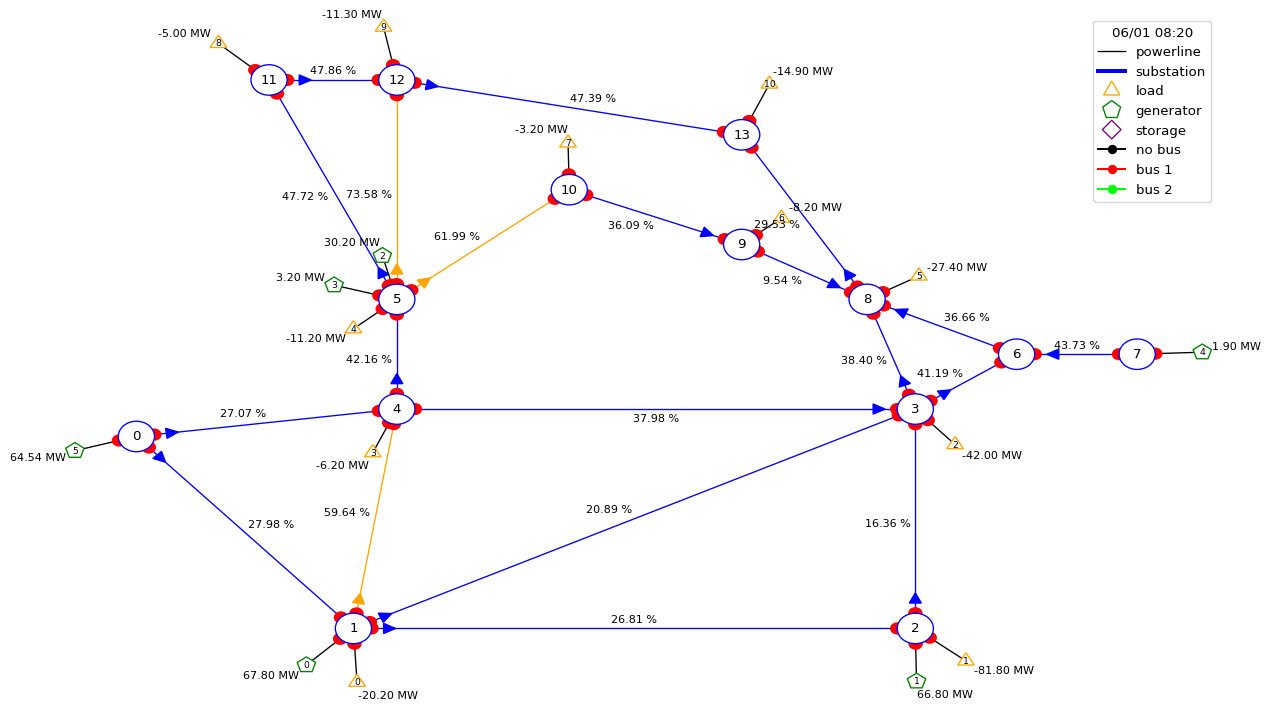

In [77]:
from stable_baselines3 import DQN

def train_dqn_agent():
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs, _ = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()



In [78]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    return episode_rewards

In [17]:
import numpy as np

class FlattenObservationWrapper(gym.Wrapper):
    def __init__(self, env):
        super(FlattenObservationWrapper, self).__init__(env)
        obs_space = self.observation_space
        
        # Check if obs_space.shape is valid
        if obs_space.shape is None:
            raise ValueError("Observation space shape is None. Please check the environment's observation space.")

        # Flatten the observation space
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(np.prod(obs_space.shape),), dtype=np.float32
        )

        print("Original observation space:", self._gym_env.observation_space)
        
# Modified Gym2OpEnv to include flattening
class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op environment
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        # Flatten the observation space using a wrapper
        self._gym_env = FlattenObservationWrapper(self._gym_env)

        self.setup_observations()
        self.setup_actions()

        self.observation_space = self._gym_env.observation_space
        self.action_space = self._gym_env.action_space

    def setup_observations(self):
        print("WARNING: setup_observations is not doing anything. Implement your own code in this method.")

    def setup_actions(self):
        print("WARNING: setup_actions is not doing anything. Implement your own code in this method.")

    def reset(self, seed=None):
        return self._gym_env.reset(seed=seed, options=None)

    def step(self, action):
        return self._gym_env.step(action)

    def render(self):
        return self._gym_env.render()


In [18]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

ValueError: Observation space shape is None. Please check the environment's observation space.

In [21]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

# Gym2OpEnv from previous code

def train_dqn_agent():
    # Create the environment (vectorized for parallelism if needed)
    env = make_vec_env(lambda: Gym2OpEnv(), n_envs=1)

    # Create the DQN model
    model = DQN("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=10000)

    # Save the model
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step+1))
            break

if __name__ == "__main__":
    train_dqn_agent()


AssertionError: Dict space must have ordered subspaces